In [136]:
%matplotlib inline

# imports

import pandas as pd
from torchvision.io import read_image, ImageReadMode
from torchvision import *
from builtins import range
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

In [137]:
# const

#DIR_PATH = "../dataset/brain-tumor-mri"
DIR_PATH = "C:\\Users\\elena\\Desktop\\universidad\\3º año\\FSI\\pythorch\\notes\\brain-tumor-mri-dataset"
LABELS = ["notumor", "glioma", "meningioma", "pituitary"]

TRAIN_PERCENT = .7
VAL_PERCENT = .2
TEST_PERCENT = .1

IMAGE_SIZE = 220

RANDOM_STATE = None

BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCH = 100

# Data Manipulation

In [138]:
# creamos un dataset de la forma (path, class)
dataset = pd.DataFrame(columns = ["path", "label"])


for dir in os.listdir(DIR_PATH):
    for label in os.listdir(os.path.join(DIR_PATH, dir)):
        for img in os.listdir(os.path.join(DIR_PATH, dir, label)):
            dataset.loc[len(dataset)] = {"path": os.path.join(DIR_PATH, dir, label, img),
                                   "label": LABELS.index(label) }


print("num elementos:", dataset.count(axis=1).size)
print(dataset.head())

num elementos: 7023
                                                path  label
0  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
1  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
2  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
3  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
4  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1


In [139]:
min_cat_size = dataset.label.value_counts().min()

print("> Cantidad de imagenes de la categoria que menos tiene:", min_cat_size)

> Cantidad de imagenes de la categoria que menos tiene: 1621


In [140]:
# Hacemos que todos tengan los mismos elementos
dataset = pd.DataFrame(dataset.groupby("label").apply(lambda label: label.sample(min_cat_size, random_state=RANDOM_STATE)).reset_index(drop=True))

print("> Cantidad de elementos: ", dataset.count(axis=1).size)
print(dataset.label.value_counts())
print(dataset.head())

> Cantidad de elementos:  6484
label
0    1621
1    1621
2    1621
3    1621
Name: count, dtype: int64
                                                path  label
0  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
1  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
2  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
3  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
4  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0


In [141]:
# separamos en los cjtos de entrenamiento
train_dataset, tmp = train_test_split(dataset, train_size=TRAIN_PERCENT, stratify=dataset["label"], shuffle=True, random_state=RANDOM_STATE)
val_dataset, test_dataset = train_test_split(tmp, test_size=TEST_PERCENT/(TEST_PERCENT+VAL_PERCENT), stratify=tmp["label"], shuffle=True, random_state=RANDOM_STATE)

print("> train", train_dataset.count(axis=1).size, train_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(train_dataset.label.value_counts())
print()

print("> val", val_dataset.count(axis=1).size, val_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(val_dataset.label.value_counts())
print()

print("> test", test_dataset.count(axis=1).size, test_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(test_dataset.label.value_counts())
print()

> train 4538 0.6998766193707588
label
0    1135
3    1135
2    1134
1    1134
Name: count, dtype: int64

> val 1297 0.2000308451573103
label
2    325
3    324
0    324
1    324
Name: count, dtype: int64

> test 649 0.10009253547193091
label
1    163
2    162
0    162
3    162
Name: count, dtype: int64


# Preparations

## Classes

In [142]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx) -> (str, int):
        
        row = self.dataframe.iloc[idx]
        img, label = row.path, row.label

        img = read_image(img, mode=ImageReadMode.GRAY)
        if self.transform: img = self.transform(img)

        return img, label

In [143]:
class EarlyStopping:
    
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta

        self.early_stop = False
        self.counter = 1

        self.best_model = None
        self.best_loss = float("inf")

    def __call__(self, val_loss, model):

        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0

            self.best_model = model.state_dict()
            return False


        self.counter += 1
        if self.counter >= self.patience: return True

    def reset(self):
        self.early_stop = False
        self.counter = 1

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, padding='same')
        self.bn1 = nn.BatchNorm2d(64)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, padding='same')
        self.bn2 = nn.BatchNorm2d(128)

        # Convolutional layer 3
        self.conv3 = nn.Conv2d(128, 128, kernel_size=7, padding='same')
        self.bn3 = nn.BatchNorm2d(128)

        # Convolutional layer 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=7, padding='same')
        self.bn4 = nn.BatchNorm2d(256)

        # Convolutional layer 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=7, padding='same')
        self.bn5 = nn.BatchNorm2d(256)

        # Convolutional layer 6
        self.conv6 = nn.Conv2d(256, 512, kernel_size=7, padding='same')
        self.bn6 = nn.BatchNorm2d(512)

        # Fully connected layers
        self.fc1 = nn.Linear(4608, 1024)  # Dimension might need adjustment
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(512, 4)

    def forward(self, x):
        # Convolutional layers with ReLU activations and batch normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No activation, as this will be included in the loss function

        return x

# Create the model
model = CNN()


## Functions

In [145]:
def eval(model, loader, *, device = None, criterion = None):
    """returns pred, real, accuracy, val_loss"""
    if not (device and criterion): raise Exception("Params needed")

    model.eval()

    corrects = 0

    pred = []
    real = []
    loss = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            
            imgs, labels = imgs.to(device), labels.to(device)

            outs = model(imgs)
            _, predicted = torch.max(outs, 1)

            loss += criterion(outs, labels).item()

            total += labels.size(0)
            pred.extend(predicted.tolist())
            real.extend(labels.tolist())

            corrects += (predicted == labels).sum().item()
    #print(metrics.classification_report(targets, preds, zero_division=0))
    return  pred, real, loss/len(loader), corrects/total

In [146]:
def train_loop(model, loader, *, optimizer, criterion, num_epoch=100, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), train_loss_h=[], train_acc_h=[], val_loss_h=[] ,val_acc_h=[], early_stopping, callback=lambda **_: None, early_callback=lambda **_: None,scheduler):
    if not (optimizer and criterion and early_stopping): raise Exception("Params needed")

    message_controler = int(len(loader)*.2)
    
    preds, labels, val_loss, val_acc  = eval(model, val_loader, device=device, criterion=criterion)
    #callback(epoch=0, val_acc=val_acc, val_loss=val_loss, train_loss=float("inf"), train_acc=0)

    for epoch in range(num_epoch):
        
        running_loss = 0.0
        corrects = 0
        total = 0

        for i, (imgs, labels) in enumerate(loader, 1):
            model.train()

            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outs = model(imgs)
            loss = criterion(outs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # extra for analytics
            _, predicted = torch.max(outs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()
            # ==================
            '''
            if not i % message_controler:
                print(f"\tEpoch {epoch+1}, Batch {i}, Loss, {running_loss/message_controler:.4f}")
            '''
        preds, labels, val_loss, val_acc  = eval(model, val_loader, device=device, criterion=criterion)
    
        # extra for analytics
        train_loss = running_loss /len(loader)
        train_loss_h.append(train_loss)
        train_acc = 100*corrects/total
        train_acc_h.append(train_acc)
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
        val_loss_h.append(val_loss)
        val_acc_h.append(val_acc*100)
        # ===================
        scheduler.step(val_acc*100)
    
        if(early_stopping(val_loss, model)):
            early_callback(model=model, early_stopping=early_stopping)
            break

    return train_acc_h, val_acc_h, train_loss_h, val_loss_h, preds, labels

# Utils

In [147]:
def save_model(model, path, complete=False):
    try:
        torch.save(model if complete else model.state_dict(), path)
    except Exception as e:
        print("Error al guardar el model:", e)

In [148]:
def show_img(img, label):
    print('Label: ', dataset.label[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

## Dataset statistics

In [149]:
unnormalized_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.ToTensor()
])

unnormalized_dataset = CustomDataset(dataset, transform=unnormalized_transforms)
loader = DataLoader(unnormalized_dataset, batch_size=32, shuffle=False)

sum_intensity = 0.0
sum_squared_intensity = 0.0
n_samples = 0

for imgs, _ in loader:
    
    sum_intensity += imgs.sum()
    sum_squared_intensity += (imgs ** 2).sum()
    n_samples += imgs.numel()

mean = sum_intensity / n_samples
std = torch.sqrt(sum_squared_intensity / n_samples - mean ** 2)

print(mean)
print(std)

tensor(0.1838)
tensor(0.1991)


In [150]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.RandomRotation(180),            
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])




train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=test_valid_transforms)
test_dataset = CustomDataset(test_dataset, transform=test_valid_transforms)

# Acceder e imprimir las primeras 5 muestras del dataset

for i in range(5):
    image, label = train_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")  

# Imprimir los valores de la media y la desviación estándar
print(f"Media: {mean}, Desviación Estándar: {std}")


Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 2
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 0
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 3
Muestra 3: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 1
Muestra 4: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 1
Media: 0.1838407665491104, Desviación Estándar: 0.19908808171749115


Batch de imágenes: torch.Size([64, 1, 220, 220]), Batch de etiquetas: torch.Size([64])
Label:  0 (3)


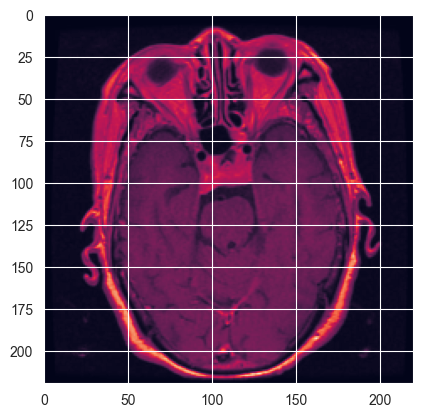

In [151]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Verificar DataLoader
for images, labels in train_loader:
    print(f"Batch de imágenes: {images.shape}, Batch de etiquetas: {labels.shape}")
    break

# Carga una imagen de prueba
img, label = test_dataset[45]
show_img(img, label)

## Comprobaciones previas de la GPU

In [152]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado para usar: {device}")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.1.2+cu121
Dispositivo configurado para usar: cuda
True
NVIDIA GeForce RTX 2060


## Entrenamos

In [153]:
early_stopping = EarlyStopping(patience=10, min_delta=.001)

In [154]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
#model = models.resnet50(pretrained=True)
#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs,4)  
#resnet50(weights=ResNet50_Weights.DEFAULT)
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
# Definir el optimizador (SGD en este caso)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
# Definir el scheduler ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=6, verbose=True)
def callback(**kwargs):
    print(f"Epoch: {kwargs['epoch']}, val_loss: {(kwargs['val_loss']):.4f}, val_acc: {(kwargs['val_acc']*100):.4f}")


def early_callback(**kwargs): print("> Early stopping <")

train_acc_h, val_acc_h, train_loss_h, val_loss_h, preds, targets = train_loop(model, train_loader,
           optimizer=optimizer,
           criterion=criterion,
           num_epoch=NUM_EPOCH,
           device=device,
           early_stopping=early_stopping,
           early_callback=early_callback,
           callback=callback,
            scheduler=scheduler
           )

Epoch 1: Train Loss: 0.8361, Train Accuracy: 65.45%, Val Loss: 0.7275, Val Accuracy: 0.69%
Epoch 2: Train Loss: 0.6369, Train Accuracy: 74.44%, Val Loss: 0.7715, Val Accuracy: 0.66%
Epoch 3: Train Loss: 0.5441, Train Accuracy: 78.43%, Val Loss: 0.7831, Val Accuracy: 0.68%
Epoch 4: Train Loss: 0.4732, Train Accuracy: 81.75%, Val Loss: 0.4600, Val Accuracy: 0.81%
Epoch 5: Train Loss: 0.3851, Train Accuracy: 85.81%, Val Loss: 0.5228, Val Accuracy: 0.78%
Epoch 6: Train Loss: 0.3615, Train Accuracy: 86.27%, Val Loss: 0.3576, Val Accuracy: 0.86%
Epoch 7: Train Loss: 0.3246, Train Accuracy: 88.12%, Val Loss: 0.3331, Val Accuracy: 0.88%
Epoch 8: Train Loss: 0.2749, Train Accuracy: 90.13%, Val Loss: 0.3887, Val Accuracy: 0.86%
Epoch 9: Train Loss: 0.2708, Train Accuracy: 89.97%, Val Loss: 0.3441, Val Accuracy: 0.85%
Epoch 00009: reducing learning rate of group 0 to 2.0000e-03.
Epoch 10: Train Loss: 0.1919, Train Accuracy: 92.99%, Val Loss: 0.1649, Val Accuracy: 0.94%
Epoch 11: Train Loss: 0.165

# Analizamos los datos

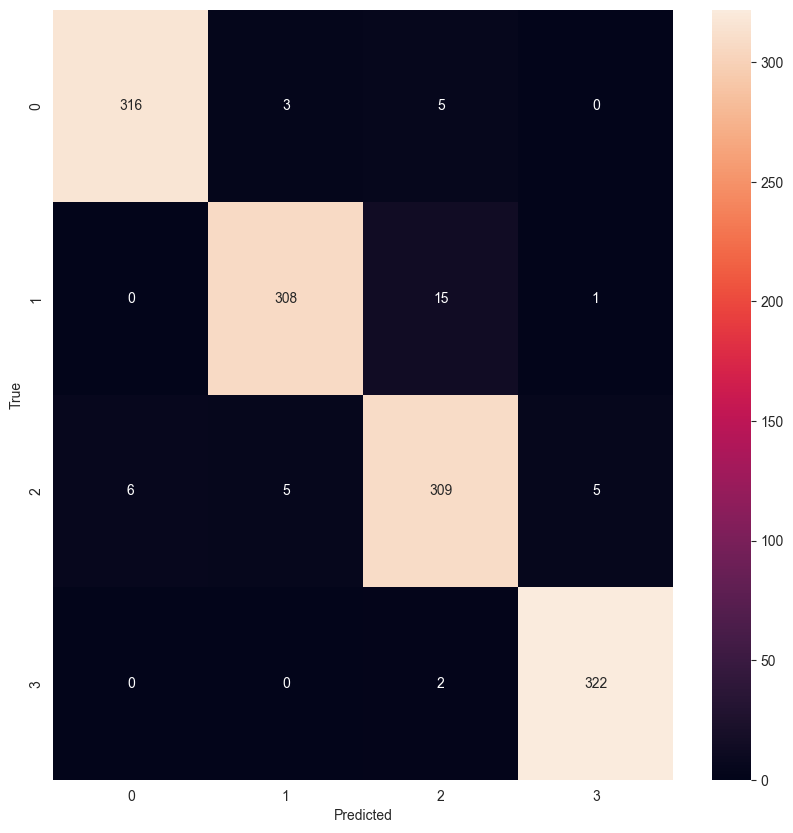

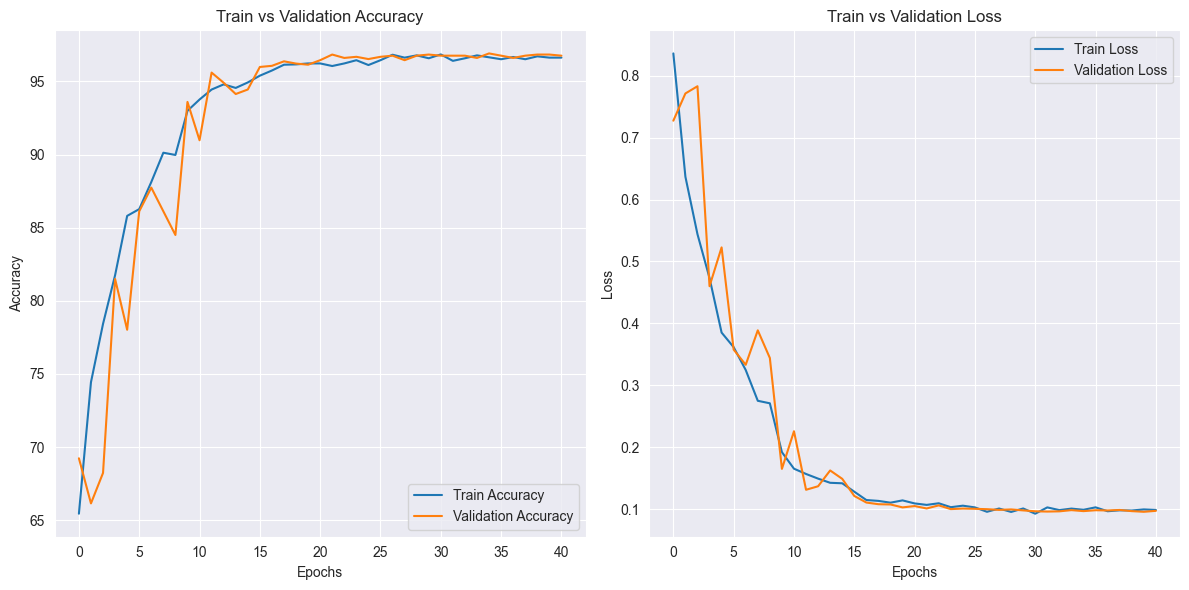

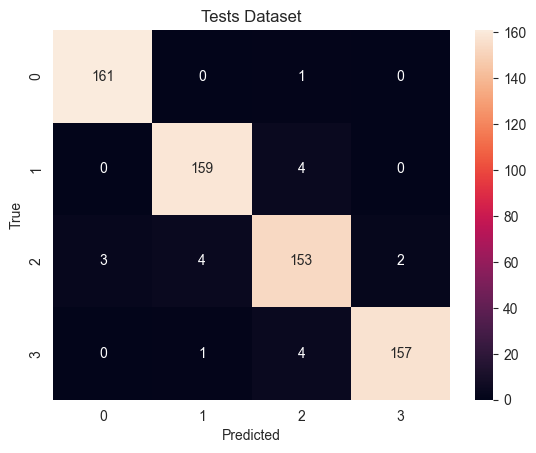

Tests Dataset ----------------------------------------------------------------
test_loss: 0.10518958588892763 - test_acc: 0.9707241910631741


In [155]:
cm = metrics.confusion_matrix(targets, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Gráfico de la precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_h, label='Train Accuracy')
plt.plot(val_acc_h, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_loss_h, label='Train Loss')
plt.plot(val_loss_h, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# cjto de tests
tests_preds, tests_reals, test_loss, test_acc = eval(model, test_loader, device=device, criterion=criterion)
cm = metrics.confusion_matrix(tests_reals, tests_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Tests Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Tests Dataset ----------------------------------------------------------------")
print(f"test_loss: {test_loss} - test_acc: {test_acc}")